# Creación de modelos para predicción de tópicos éticos

## 0. Pre procesamiento

In [1]:
import pandas as pd
import os

def procesar_caso(caso):
    """
    Procesa los archivos ETHIC_Topics_df1.csv y ETHIC_Topics_df2.csv para un caso dado
    y guarda el resultado como un archivo CSV en la carpeta "data/".

    Args:
        caso (str): Nombre del caso (por ejemplo, "Amanda 2023").
    
    Returns:
        pd.DataFrame: DataFrame combinado y procesado.
    """
    # Construir las rutas de los archivos
    ruta_base = f"../processed_data/{caso}"
    archivo_d1 = f"{ruta_base}/ETHIC_Topics_df1.csv"
    archivo_d2 = f"{ruta_base}/ETHIC_Topics_df2.csv"

    # Leer los archivos
    d1 = pd.read_csv(archivo_d1)
    d2 = pd.read_csv(archivo_d2)

    # Procesar el primer diferencial
    d1_label_ind1 = d1[["Comentario - Ind1 - Diferencial 1", "ETHIC_topicos_ind1"]].rename(
        columns={"Comentario - Ind1 - Diferencial 1": "text", "ETHIC_topicos_ind1": "label"})
    d1_label_grup = d1[["Comentario - Grup - Diferencial 1", "ETHIC_topicos_grup"]].rename(
        columns={"Comentario - Grup - Diferencial 1": "text", "ETHIC_topicos_grup": "label"})
    d1_label_ind2 = d1[["Comentario - Ind2 - Diferencial 1", "ETHIC_topicos_ind2"]].rename(
        columns={"Comentario - Ind2 - Diferencial 1": "text", "ETHIC_topicos_ind2": "label"})

    df_d1 = pd.concat([d1_label_ind1, d1_label_grup, d1_label_ind2], ignore_index=True).drop_duplicates(subset=["text"])

    # Procesar el segundo diferencial
    d2_label_ind1 = d2[["Comentario - Ind1 - Diferencial 2", "ETHIC_topicos_ind1"]].rename(
        columns={"Comentario - Ind1 - Diferencial 2": "text", "ETHIC_topicos_ind1": "label"})
    d2_label_grup = d2[["Comentario - Grup - Diferencial 2", "ETHIC_topicos_grup"]].rename(
        columns={"Comentario - Grup - Diferencial 2": "text", "ETHIC_topicos_grup": "label"})
    d2_label_ind2 = d2[["Comentario - Ind2 - Diferencial 2", "ETHIC_topicos_ind2"]].rename(
        columns={"Comentario - Ind2 - Diferencial 2": "text", "ETHIC_topicos_ind2": "label"})

    df_d2 = pd.concat([d2_label_ind1, d2_label_grup, d2_label_ind2], ignore_index=True).drop_duplicates(subset=["text"])

    # Combinar ambos diferenciales y eliminar duplicados
    df_combined = pd.concat([df_d1, df_d2], ignore_index=True).drop_duplicates(subset=["text"])

    # Crear la carpeta "data/" si no existe
    os.makedirs("data", exist_ok=True)

    # Guardar el resultado como CSV
    ruta_salida = f"data/{caso.replace(' ', '_')}.csv"
    df_combined.to_csv(ruta_salida, index=False)

    print(f"Caso {caso} procesado")
    return df_combined

# Uso:
procesar_caso("Amanda 2024")
procesar_caso("Amanda 2023")
procesar_caso("Adela 2023")
procesar_caso("Adela 2022")

# Concatenar archivos csv de los casos
def summarize():
    # Leer los archivos usando os
    archivos = os.listdir("data/")
    dfs = [pd.read_csv(f"data/{archivo}") for archivo in archivos]

    # Concatenar los DataFrames
    df_concat = pd.concat(dfs, ignore_index=True)

    # Eliminar archivos 
    for archivo in archivos:
        os.remove(f"data/{archivo}")
    # Guardar el resultado
    df_concat.to_csv("data/data.csv", index=False)
    print("Data guardada en: 'data/data.csv'")

summarize()

Caso Amanda 2024 procesado
Caso Amanda 2023 procesado
Caso Adela 2023 procesado
Caso Adela 2022 procesado
Data guardada en: 'data/data.csv'


In [2]:
import ast

# Leer el archivo CSV
df = pd.read_csv("data/data.csv")
# Procesar la columna "label"
df['label'] = df['label'].apply(ast.literal_eval)
# Pasar toda la columa text a string
df['text'] = df['text'].astype(str)

In [9]:
import re
import spacy
import nltk
from nltk.corpus import stopwords

# Descargar recursos necesarios (solo la primera vez)
nltk.download('stopwords')

# Cargar modelo de SpaCy para español
nlp = spacy.load('es_core_news_md')

# Stopwords en español
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = text.lower()
    
    # 2. Eliminar caracteres especiales, números y puntuación
    text = re.sub(r"[^a-záéíóúñü\s]", "", text)
    
    # 3. Procesar texto con SpaCy para lematización
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct]
    
    # 4. Unir palabras en un solo string
    text = " ".join(words)
    
    # 5. Eliminar espacios adicionales
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Aplicar preprocesamiento a la columna "text"
df['text_processed'] = df['text'].apply(preprocess_text)

# Guardar el resultado
df.to_csv("data/data.csv", index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pbast\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 0.1 Tokens

In [ ]:
def tokenize_text(text):
    tokens = text.split()
    return tokens

# Aplicar tokenización y guardar en CSV
def save_tokenized_csv(df, column, output_path):
    df['tokens'] = df[column].apply(tokenize_text)
    df.to_csv(output_path, index=False)

### 0.2 N-grams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def generate_ngrams(text, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n), token_pattern=r'\b\w+\b')
    ngrams = vectorizer.fit_transform([text])
    ngram_features = vectorizer.get_feature_names_out()
    return ngram_features

# Aplicar generación de n-gramas y guardar en CSV
def save_ngrams_csv(df, column, n, output_path):
    df[f'{n}_grams'] = df[column].apply(lambda text: generate_ngrams(text, n))
    df.to_csv(output_path, index=False)

#### 0.3 Subword tokenization para BERT

In [ ]:
from transformers import BertTokenizer

# Cargar tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def bert_tokenization(text):
    tokens = tokenizer.tokenize(text)
    return tokens

# Aplicar tokenización de subwords y guardar en CSV
def save_bert_tokens_csv(df, column, output_path):
    df['bert_tokens'] = df[column].apply(bert_tokenization)
    df.to_csv(output_path, index=False)


### 0.4 Representaciones vectoriales: Bag of Words (BoW)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def get_bow(texts):
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(texts)
    return bow_matrix, vectorizer

### 0.5 Representaciones vectoriales: TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(texts):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix, vectorizer

### 0.6 Representaciones vectoriales: Word2Vec

In [11]:
from gensim.models import Word2Vec

def get_word2vec(sentences, vector_size=100, window=5, min_count=1):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)
    return model

### 0.7 Representaciones vectoriales: GloVe

In [12]:
# GloVe requiere descargar previamente embeddings preentrenados
from gensim.models import KeyedVectors

def load_glove_model(glove_file):
    model = KeyedVectors.load_word2vec_format(glove_file, binary=False)
    return model


### 0.8 BERT

In [13]:
from transformers import BertModel

def get_bert_embeddings(texts):
    model = BertModel.from_pretrained('bert-base-multilingual-cased')
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state

### 0.9 One Hot Encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def get_one_hot_encoding(texts):
    encoder = OneHotEncoder(sparse=False)
    one_hot = encoder.fit_transform([[text] for text in texts])
    return one_hot, encoder

## Obtener representaciones

In [ ]:
bow_matrix, bow_vectorizer = get_bow(df['processed_text'])
tfidf_matrix, tfidf_vectorizer = get_tfidf(df['processed_text'])
word2vec_model = get_word2vec(df['processed_text'].apply(lambda x: x.split()))
glove_model = load_glove_model('path_to_glove_file.txt')
bert_embeddings = get_bert_embeddings(df['processed_text'].tolist())
one_hot, encoder = get_one_hot_encoding(df['processed_text'])

## Modelos estadísticos

### LDA (Latent Dirichlet Allocation)
* Encuentra temas basados en la frecuencia de palabras en el texto

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

# Vectorización (Bag of Words)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["text_processed"])

# Modelo LDA
n_topics = 41 
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(X)

# Palabras clave de cada tema
def print_lda_topics(model, feature_names, n_words=5):
    for idx, topic in enumerate(model.components_):
        print(f"Tema {idx}: ", [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]])

print("\nLDA Topics:")
print_lda_topics(lda_model, vectorizer.get_feature_names_out())


LDA Topics:
Tema 0:  ['algoritm', 'enfermed', 'explic', 'exactitud', 'detect']
Tema 1:  ['import', 'salud', 'deb', 'tal', 'exactitud']
Tema 2:  ['pued', 'podr', 'person', 'quizas', 'mayor']
Tema 3:  ['sig', 'respuest', 'anterior', 'grup', 'postur']
Tema 4:  ['tradicion', 'deb', 'import', 'resguard', 'puebl']
Tema 5:  ['tradicion', 'aliment', 'produc', 'deb', 'puebl']
Tema 6:  ['recurs', 'preserv', 'natural', 'deb', 'esco']
Tema 7:  ['frut', 'puebl', 'respet', 'si', 'pued']
Tema 8:  ['lleg', 'acuerd', 'puebl', 'originari', 'respet']
Tema 9:  ['agu', 'sector', 'gran', 'poblacion', 'afect']
Tema 10:  ['grup', 'person', 'mayor', 'consider', 'edad']
Tema 11:  ['exactitud', 'explic', 'mayor', 'algoritm', 'mejor']
Tema 12:  ['frut', 'puebl', 'tradicion', 'originari', 'si']
Tema 13:  ['proyect', 'frut', 'si', 'diaguit', 'comun']
Tema 14:  ['vitamin', 'deficit', 'obtar', 'pued', 'exist']
Tema 15:  ['aliment', 'gent', 'puebl', 'import', 'pued']
Tema 16:  ['import', 'salud', 'tem', 'si', 'aun']


In [37]:
# TF-IDF
print("\nLDA Topics (usando TF-IDF):")
print_lda_topics(lda_model, tfidf_vectorizer.get_feature_names_out())


LDA Topics (usando TF-IDF):
Tema 0:  ['algoritm', 'enfermed', 'explic', 'exactitud', 'detect']
Tema 1:  ['import', 'salud', 'deb', 'tal', 'exactitud']
Tema 2:  ['pued', 'podr', 'person', 'quizas', 'mayor']
Tema 3:  ['sig', 'respuest', 'anterior', 'grup', 'postur']
Tema 4:  ['tradicion', 'deb', 'import', 'resguard', 'puebl']
Tema 5:  ['tradicion', 'aliment', 'produc', 'deb', 'puebl']
Tema 6:  ['recurs', 'preserv', 'natural', 'deb', 'esco']
Tema 7:  ['frut', 'puebl', 'respet', 'si', 'pued']
Tema 8:  ['lleg', 'acuerd', 'puebl', 'originari', 'respet']
Tema 9:  ['agu', 'sector', 'gran', 'poblacion', 'afect']
Tema 10:  ['grup', 'person', 'mayor', 'consider', 'edad']
Tema 11:  ['exactitud', 'explic', 'mayor', 'algoritm', 'mejor']
Tema 12:  ['frut', 'puebl', 'tradicion', 'originari', 'si']
Tema 13:  ['proyect', 'frut', 'si', 'diaguit', 'comun']
Tema 14:  ['vitamin', 'deficit', 'obtar', 'pued', 'exist']
Tema 15:  ['aliment', 'gent', 'puebl', 'import', 'pued']
Tema 16:  ['import', 'salud', 'tem

In [38]:
# BoW
print("\nLDA Topics (usando BoW):")
print_lda_topics(lda_model, bow_vectorizer.get_feature_names_out())


LDA Topics (usando BoW):
Tema 0:  ['algoritm', 'enfermed', 'explic', 'exactitud', 'detect']
Tema 1:  ['import', 'salud', 'deb', 'tal', 'exactitud']
Tema 2:  ['pued', 'podr', 'person', 'quizas', 'mayor']
Tema 3:  ['sig', 'respuest', 'anterior', 'grup', 'postur']
Tema 4:  ['tradicion', 'deb', 'import', 'resguard', 'puebl']
Tema 5:  ['tradicion', 'aliment', 'produc', 'deb', 'puebl']
Tema 6:  ['recurs', 'preserv', 'natural', 'deb', 'esco']
Tema 7:  ['frut', 'puebl', 'respet', 'si', 'pued']
Tema 8:  ['lleg', 'acuerd', 'puebl', 'originari', 'respet']
Tema 9:  ['agu', 'sector', 'gran', 'poblacion', 'afect']
Tema 10:  ['grup', 'person', 'mayor', 'consider', 'edad']
Tema 11:  ['exactitud', 'explic', 'mayor', 'algoritm', 'mejor']
Tema 12:  ['frut', 'puebl', 'tradicion', 'originari', 'si']
Tema 13:  ['proyect', 'frut', 'si', 'diaguit', 'comun']
Tema 14:  ['vitamin', 'deficit', 'obtar', 'pued', 'exist']
Tema 15:  ['aliment', 'gent', 'puebl', 'import', 'pued']
Tema 16:  ['import', 'salud', 'tem', 

### LSA (Latent Semantic Analysis)

* Utiliza descomposición SVD (Singular Value Descomposition) en una matriz TF-IDF para encontrar conceptos latentes.

In [35]:
from sklearn.decomposition import TruncatedSVD

# BoW
bow_matrix, bow_vectorizer = get_bow(df["text_processed"])

# TF-IDF
tfidf_matrix, tfidf_vectorizer = get_tfidf(df["text_processed"])

# Modelo LSA
n_components = 41  # Ajusta el número de conceptos según tu dataset
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)

# Cambia entre BoW y TF-IDF aquí:
lsa_model.fit(tfidf_matrix)  # Cambia a `bow_matrix` si prefieres usar BoW

# Palabras clave de cada concepto
def print_lsa_topics(model, feature_names, n_words=5):
    for idx, topic in enumerate(model.components_):
        print(f"Concepto {idx}: ", [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]])


In [33]:
# TF-IDF
print("\nLSA Topics (usando TF-IDF):")
print_lsa_topics(lsa_model, tfidf_vectorizer.get_feature_names_out())


LSA Topics (usando TF-IDF):
Concepto 0:  ['deb', 'import', 'aliment', 'pued', 'agu']
Concepto 1:  ['algoritm', 'error', 'mayor', 'enfermed', 'explic']
Concepto 2:  ['agu', 'recurs', 'preserv', 'natural', 'hidric']
Concepto 3:  ['poblacion', 'error', 'migrant', 'promedi', 'menor']
Concepto 4:  ['import', 'salud', 'niñ', 'person', 'tradicion']
Concepto 5:  ['deb', 'natural', 'recurs', 'preserv', 'esco']
Concepto 6:  ['aliment', 'deb', 'prioriz', 'produc', 'produccion']
Concepto 7:  ['solucion', 'problem', 'tradicion', 'salud', 'deb']
Concepto 8:  ['benefici', 'salud', 'niñ', 'person', 'si']
Concepto 9:  ['problem', 'solucion', 'opinion', 'grup', 'mism']
Concepto 10:  ['deb', 'agu', 'si', 'bien', 'comun']
Concepto 11:  ['person', 'grup', 'vid', 'cantid', 'vitamin']
Concepto 12:  ['enfermed', 'detect', 'puebl', 'person', 'originari']
Concepto 13:  ['lleg', 'pued', 'acuerd', 'enfermed', 'solucion']
Concepto 14:  ['agu', 'mayor', 'vitamin', 'niñ', 'salud']
Concepto 15:  ['si', 'bien', 'enfe

In [34]:
# BoW
print("\nLSA Topics (usando BoW):")
print_lsa_topics(lsa_model, bow_vectorizer.get_feature_names_out())


LSA Topics (usando BoW):
Concepto 0:  ['deb', 'import', 'aliment', 'pued', 'agu']
Concepto 1:  ['algoritm', 'error', 'mayor', 'enfermed', 'explic']
Concepto 2:  ['agu', 'recurs', 'preserv', 'natural', 'hidric']
Concepto 3:  ['poblacion', 'error', 'migrant', 'promedi', 'menor']
Concepto 4:  ['import', 'salud', 'niñ', 'person', 'tradicion']
Concepto 5:  ['deb', 'natural', 'recurs', 'preserv', 'esco']
Concepto 6:  ['aliment', 'deb', 'prioriz', 'produc', 'produccion']
Concepto 7:  ['solucion', 'problem', 'tradicion', 'salud', 'deb']
Concepto 8:  ['benefici', 'salud', 'niñ', 'person', 'si']
Concepto 9:  ['problem', 'solucion', 'opinion', 'grup', 'mism']
Concepto 10:  ['deb', 'agu', 'si', 'bien', 'comun']
Concepto 11:  ['person', 'grup', 'vid', 'cantid', 'vitamin']
Concepto 12:  ['enfermed', 'detect', 'puebl', 'person', 'originari']
Concepto 13:  ['lleg', 'pued', 'acuerd', 'enfermed', 'solucion']
Concepto 14:  ['agu', 'mayor', 'vitamin', 'niñ', 'salud']
Concepto 15:  ['si', 'bien', 'enferme

#### Métricas

- 90%-95%: Si deseas capturar casi toda la información de los datos. Este es un estándar común en análisis dimensional.
- 80%-85%: Si quieres reducir más la dimensionalidad mientras conservas información significativa.
- 60%-70%: Útil si buscas un modelo más ligero y estás dispuesto a sacrificar algo de precisión en favor de velocidad o simplicidad.
<br><br>
Codo en la Gráfica:
<br>
- Observa la gráfica de varianza explicada acumulada. Elige el valor de n_components donde la ganancia marginal (pendiente) comienza a disminuir significativamente. Este punto, llamado el "codo", es una buena elección porque representa un equilibrio entre simplicidad y retención de información.

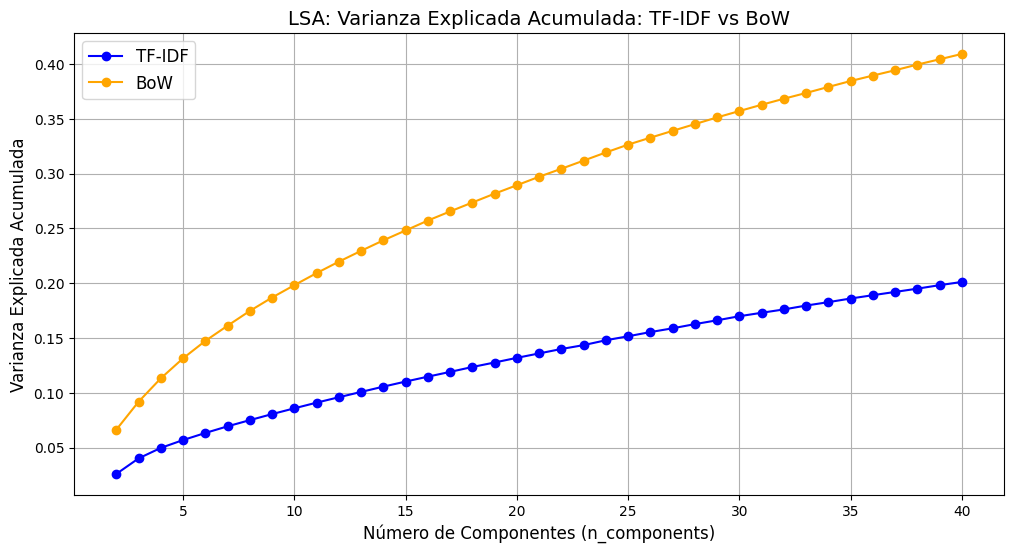

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Vectorización con TF-IDF
tfidf_matrix, tfidf_vectorizer = get_tfidf(df["text_processed"])

# Vectorización con BoW
bow_matrix, bow_vectorizer = get_bow(df["text_processed"])

# components
n_components = 41

# Listas para almacenar varianza explicada acumulada
explained_variance_ratios_tfidf = []
explained_variance_ratios_bow = []

# Probar n_components de 2 a 20
for n in range(2, n_components):
    # TF-IDF
    lsa_model_tfidf = TruncatedSVD(n_components=n, random_state=42)
    lsa_model_tfidf.fit(tfidf_matrix)
    explained_variance_ratios_tfidf.append(np.sum(lsa_model_tfidf.explained_variance_ratio_))
    
    # BoW
    lsa_model_bow = TruncatedSVD(n_components=n, random_state=42)
    lsa_model_bow.fit(bow_matrix)
    explained_variance_ratios_bow.append(np.sum(lsa_model_bow.explained_variance_ratio_))

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(range(2, n_components), explained_variance_ratios_tfidf, marker='o', label="TF-IDF", color='blue')
plt.plot(range(2, n_components), explained_variance_ratios_bow, marker='o', label="BoW", color='orange')
plt.title('LSA: Varianza Explicada Acumulada: TF-IDF vs BoW', fontsize=14)
plt.xlabel('Número de Componentes (n_components)', fontsize=12)
plt.ylabel('Varianza Explicada Acumulada', fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

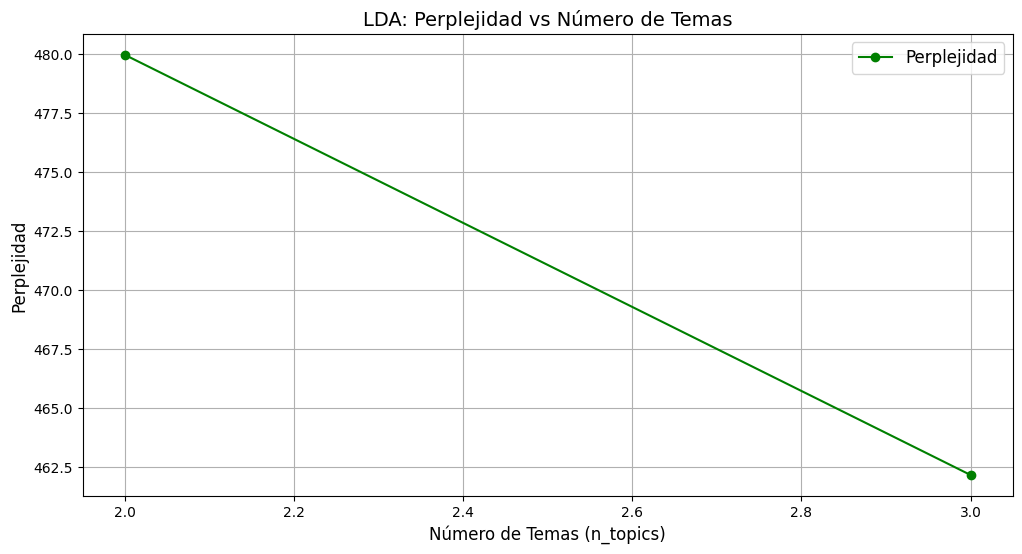

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorización (Bag of Words)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["text_processed"])

# Rango de n_components para LDA
n_topics_range = range(2, 4)  # De 2 a 20 componentes

# Listas para almacenar la perplejidad
perplexities = []

# Probar n_components de 2 a 20 para LDA
for n_topics in n_topics_range:
    # Modelo LDA
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_model.fit(X)
    
    # Calcular la perplejidad y agregarla a la lista
    perplexities.append(lda_model.perplexity(X))

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(n_topics_range, perplexities, marker='o', color='green', label='Perplejidad')
plt.title('LDA: Perplejidad vs Número de Temas', fontsize=14)
plt.xlabel('Número de Temas (n_topics)', fontsize=12)
plt.ylabel('Perplejidad', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

## Modelos de aprendizaje automático

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Supongamos que tienes un archivo 'dataset.csv' con columnas "Respuestas" y "Temas".
data = pd.read_csv("data/data.csv")

# Separar características y etiquetas
X = data["processed_text"]  # Texto
y = data["labels"]       # Tópicos esperados (pueden ser etiquetas múltiples)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorización del texto
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### SVM

In [ ]:
from sklearn.svm import LinearSVC

# Entrenar el modelo SVM
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)

# Predicción y evaluación
y_pred_svm = svm_model.predict(X_test_vec)
print("Reporte para SVM:")
print(classification_report(y_test, y_pred_svm))

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Entrenar el modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Predicción y evaluación
y_pred_nb = nb_model.predict(X_test_vec)
print("Reporte para Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

### CRF (Conditional Random Field)

In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from nltk.tokenize import word_tokenize

# Tokenización del texto
def prepare_crf_data(X, y):
    crf_data = []
    for text, topic in zip(X, y):
        tokens = word_tokenize(text)
        crf_data.append([(token, topic) for token in tokens])
    return crf_data

train_data = prepare_crf_data(X_train, y_train)
test_data = prepare_crf_data(X_test, y_test)

In [ ]:
# Configurar el modelo CRF
crf_model = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# Extraer características para CRF
def word2features(tokens, i):
    word = tokens[i][0]
    features = {
        'word': word,
        'is_first': i == 0,
        'is_last': i == len(tokens) - 1,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_digit': word.isdigit(),
    }
    return features

def extract_features(data):
    X, y = [], []
    for sentence in data:
        X.append([word2features(sentence, i) for i in range(len(sentence))])
        y.append([label for token, label in sentence])
    return X, y

X_train_crf, y_train_crf = extract_features(train_data)
X_test_crf, y_test_crf = extract_features(test_data)

# Entrenar el modelo
crf_model.fit(X_train_crf, y_train_crf)

# Predicción y evaluación
y_pred_crf = crf_model.predict(X_test_crf)
print("Reporte para CRF:")
print(flat_classification_report(y_test_crf, y_pred_crf))

## Modelos de redes neuronales

### Procesamiento de datos

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Cargar el dataset
df = pd.read_csv("dataset.csv")  # Asegúrate de tener columnas 'Respuestas' y 'temas'

# Dividir datos en entrenamiento y prueba
X = df['Respuestas'].values
y = df['temas'].values

# Tokenización
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=100, padding='post')

# Etiquetar temas como índices
topic_tokenizer = Tokenizer()
topic_tokenizer.fit_on_texts(y)
y_seq = topic_tokenizer.texts_to_sequences(y)
y_padded = pad_sequences(y_seq, maxlen=10, padding='post')

# Convertir a matrices NumPy
y_padded = np.array(y_padded)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

### RNN (Red neuronal)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Crear el modelo
rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    SimpleRNN(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_padded.shape[1], activation='softmax')  # Salida con las dimensiones de los temas
])

# Compilar
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

### LSTM (Long Short Term Memory)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Crear el modelo
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(y_padded.shape[1], activation='softmax')
])

# Compilar
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

### Seq2Seq

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# Longitud de entrada y salida
input_len = X_padded.shape[1]
output_len = y_padded.shape[1]

# Modelo Seq2Seq
encoder_inputs = Input(shape=(input_len,))
encoder_embedding = Embedding(input_dim=10000, output_dim=128)(encoder_inputs)
encoder_lstm = LSTM(128, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)

decoder_inputs = Input(shape=(output_len,))
decoder_embedding = Embedding(input_dim=10000, output_dim=128)(decoder_inputs)
decoder_lstm = LSTM(128, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

decoder_dense = Dense(len(topic_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar
seq2seq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar
decoder_inputs_train = np.zeros_like(y_train)  # Entrada inicial del decodificador
seq2seq_model.fit([X_train, decoder_inputs_train], y_train, epochs=10, batch_size=32, validation_data=([X_test, np.zeros_like(y_test)], y_test))

## Modelos basados en transformers

### Preprocesamiento

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# Cargar el dataset
df = pd.read_csv("dataset.csv")  # Cambia el nombre del archivo
df["Temas"] = df["Temas"].apply(lambda x: x.split(", "))  # Convertir a lista de temas

# Convertir los temas a formato binarizado
mlb = MultiLabelBinarizer()
df["Temas_binarizados"] = list(mlb.fit_transform(df["Temas"]))

# Dividir en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

### Entrenamiento

In [ ]:
def train_model(model_name, train_dataset, test_dataset, mlb):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(mlb.classes_))

    # Tokenización
    def tokenize_data(examples):
        return tokenizer(examples["Respuestas"], padding="max_length", truncation=True)

    train_dataset = train_dataset.map(tokenize_data, batched=True)
    test_dataset = test_dataset.map(tokenize_data, batched=True)

    # Argumentos de entrenamiento
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}", 
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir=f"./logs/{model_name}",
        logging_steps=10,
        load_best_model_at_end=True
    )

    # Entrenador
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=None  # Puedes definir métricas adicionales
    )

    # Entrenar el modelo
    trainer.train()

    return model, tokenizer

### BERT

In [ ]:
bert_model, bert_tokenizer = train_model("bert-base-uncased", train_dataset, test_dataset, mlb)

### GPT

In [ ]:
gpt_model, gpt_tokenizer = train_model("gpt2", train_dataset, test_dataset, mlb)

### T5

In [ ]:
t5_model, t5_tokenizer = train_model("t5-small", train_dataset, test_dataset, mlb)

### XLNet

In [ ]:
xlnet_model, xlnet_tokenizer = train_model("xlnet-base-cased", train_dataset, test_dataset, mlb)

### RoBERTa

In [ ]:
roberta_model, roberta_tokenizer = train_model("roberta-base", train_dataset, test_dataset, mlb)

### Predicción

In [ ]:
def predict_topics(model, tokenizer, text, mlb):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**tokens)
    predictions = outputs.logits.argmax(dim=-1).detach().numpy()
    return mlb.inverse_transform(predictions)

# Ejemplo de predicción con BERT
response_text = "Este es un ejemplo de respuesta."
predicted_topics = predict_topics(bert_model, bert_tokenizer, response_text, mlb)
print(predicted_topics)